<a href="https://colab.research.google.com/github/arifpras/ExpectedDemand/blob/main/20230108_podem01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div class="markdown-google-sans">

  <h1> Predicting Demand in the Primary Market: Pycaret</h1>
</div>

<div class="markdown-google-sans">

## <strong> Data Preparation </strong>
</div>

## Libraries

In [1]:
%%capture

# %pip install openpyxl
# %pip install shap
# %pip install pycaret

!pip show pycaret || pip install pycaret

In [2]:
# Subsequent cells can use the installed library
import pycaret
pycaret.__version__

'3.2.0'

In [3]:
from pycaret.regression import *

import numpy as np
import pandas as pd
import openpyxl as xl
import matplotlib.pyplot as plt
import seaborn as sns

## Database

### Load

In [4]:
df_train00 = pd.read_excel('/content/drive/MyDrive/00database/db_monthfrac.xlsx', sheet_name='database')
df_train00['incoming_bid'] = df_train00['incoming_bid'].astype(float)
df_train00['issuance_date'] = pd.to_datetime(df_train00['issuance_date'], format='%d/%m/%Y')

df_train00.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1888 entries, 0 to 1887
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   issued_series     1888 non-null   object        
 1   issuance_date     1888 non-null   datetime64[ns]
 2   issuance_year     1888 non-null   int64         
 3   issuance_week     1888 non-null   int64         
 4   monthfrac         1888 non-null   int64         
 5   eid_weeks         1888 non-null   int64         
 6   srbi_issuance     1888 non-null   int64         
 7   vix_indicator     1888 non-null   int64         
 8   bi_covid          1888 non-null   int64         
 9   gso_issuance      1888 non-null   int64         
 10  investment_grade  1888 non-null   int64         
 11  incoming_bid      1888 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(9), object(1)
memory usage: 177.1+ KB


In [5]:
df_train00['issued_series'].value_counts()

sun10    291
sun20    286
spn12    271
sun15    271
sun05    265
spn03    237
sun30    169
spn09     76
sun07     11
sun08      8
sun04      1
vr04       1
sun02      1
Name: issued_series, dtype: int64

In [6]:
df_train00.describe()

,issuance_year,issuance_week,monthfrac,eid_weeks,srbi_issuance,vix_indicator,bi_covid,gso_issuance,investment_grade,incoming_bid
count,1888.000000,1888.000000,1888.000000,1888.000000,1888.000000,1888.000000,1888.000000,1888.000000,1888.000000,1.888000e+03
mean,2017.113347,24.753708,124.146186,0.084216,0.026483,0.082627,0.250000,0.022775,0.859640,6.254142e+06
std,4.260947,13.995845,108.241001,0.277785,0.160609,0.275391,0.433127,0.149226,0.347452,5.915484e+06
min,2009.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00
25%,2013.000000,12.000000,12.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2.360750e+06
50%,2018.000000,25.000000,119.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,4.394550e+06
75%,2021.000000,37.000000,188.000000,0.000000,0.000000,0.000000,0.250000,0.000000,1.000000,7.984650e+06
max,2023.000000,51.000000,367.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,4.516780e+07


<Axes: xlabel='incoming_bid', ylabel='issuance_week'>

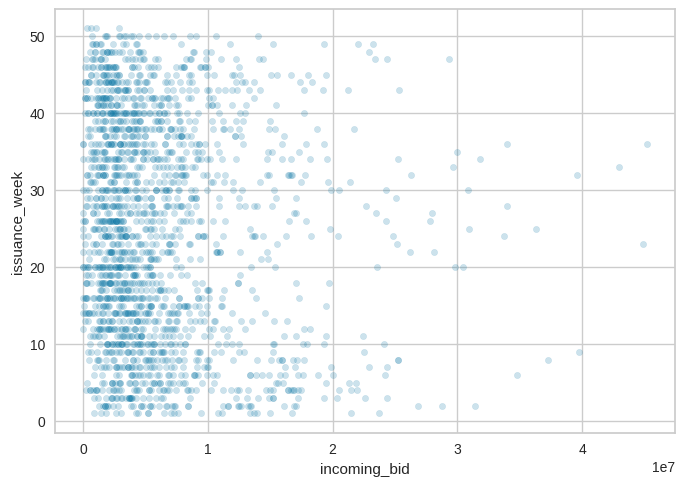

In [7]:
df_train00.plot(kind = 'scatter', x = 'incoming_bid', y = 'issuance_week', alpha = 0.2)

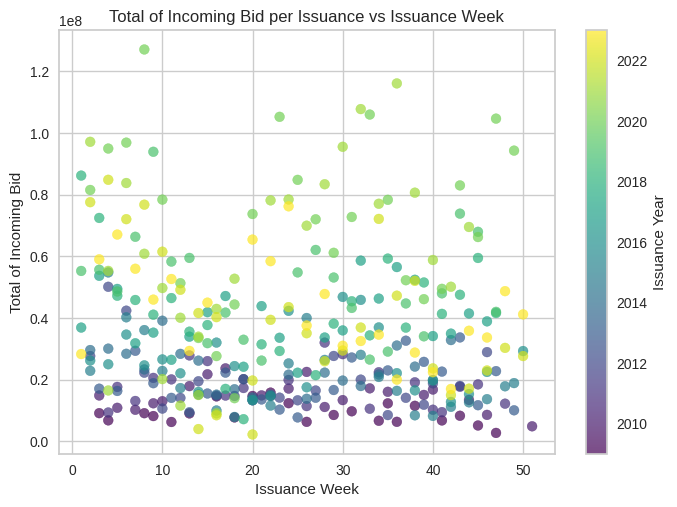

In [8]:
# import matplotlib.pyplot as plt

grouped_series01 = df_train00.groupby(['issuance_date']).agg({
    'incoming_bid': 'sum',
    'issuance_week': 'mean',
    'issuance_year': 'mean'
}).reset_index()

# Convert 'issuance_year' to integer
grouped_series01['issuance_year'] = grouped_series01['issuance_year'].astype(int)


# Scatter plot
# plt.figure(figsize=(10, 6))
plt.scatter(grouped_series01['issuance_week'], grouped_series01['incoming_bid'], s=50, c=grouped_series01['issuance_year'], alpha=0.7, cmap='viridis')
plt.title('Total of Incoming Bid per Issuance vs Issuance Week')
plt.xlabel('Issuance Week')
plt.ylabel('Total of Incoming Bid')
plt.colorbar(label='Issuance Year')
plt.grid(True)
plt.show()

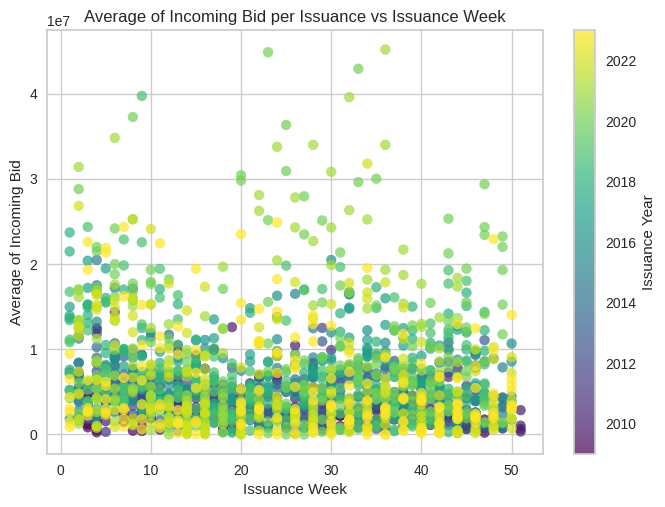

In [9]:
# import matplotlib.pyplot as plt

grouped_series02 = df_train00.groupby(['issuance_date', 'issued_series']).agg({
    'incoming_bid': 'mean', #average
    'issuance_week': 'mean',
    'issuance_year': 'mean'
}).reset_index()

# Convert 'issuance_year' to integer
grouped_series02['issuance_year'] = grouped_series02['issuance_year'].astype(int)


# Scatter plot
# plt.figure(figsize=(10, 6))
plt.scatter(grouped_series02['issuance_week'], grouped_series02['incoming_bid'], s=50, c=grouped_series02['issuance_year'], alpha=0.7, cmap='viridis')
plt.title('Average of Incoming Bid per Issuance vs Issuance Week')
plt.xlabel('Issuance Week')
plt.ylabel('Average of Incoming Bid')
plt.colorbar(label='Issuance Year')
plt.grid(True)
plt.show()

In [10]:
# sns.catplot(x='issued_series', y='incoming_bid', data=grouped_series02,
#                 kind='boxen', col='issuance_year', col_wrap=2)

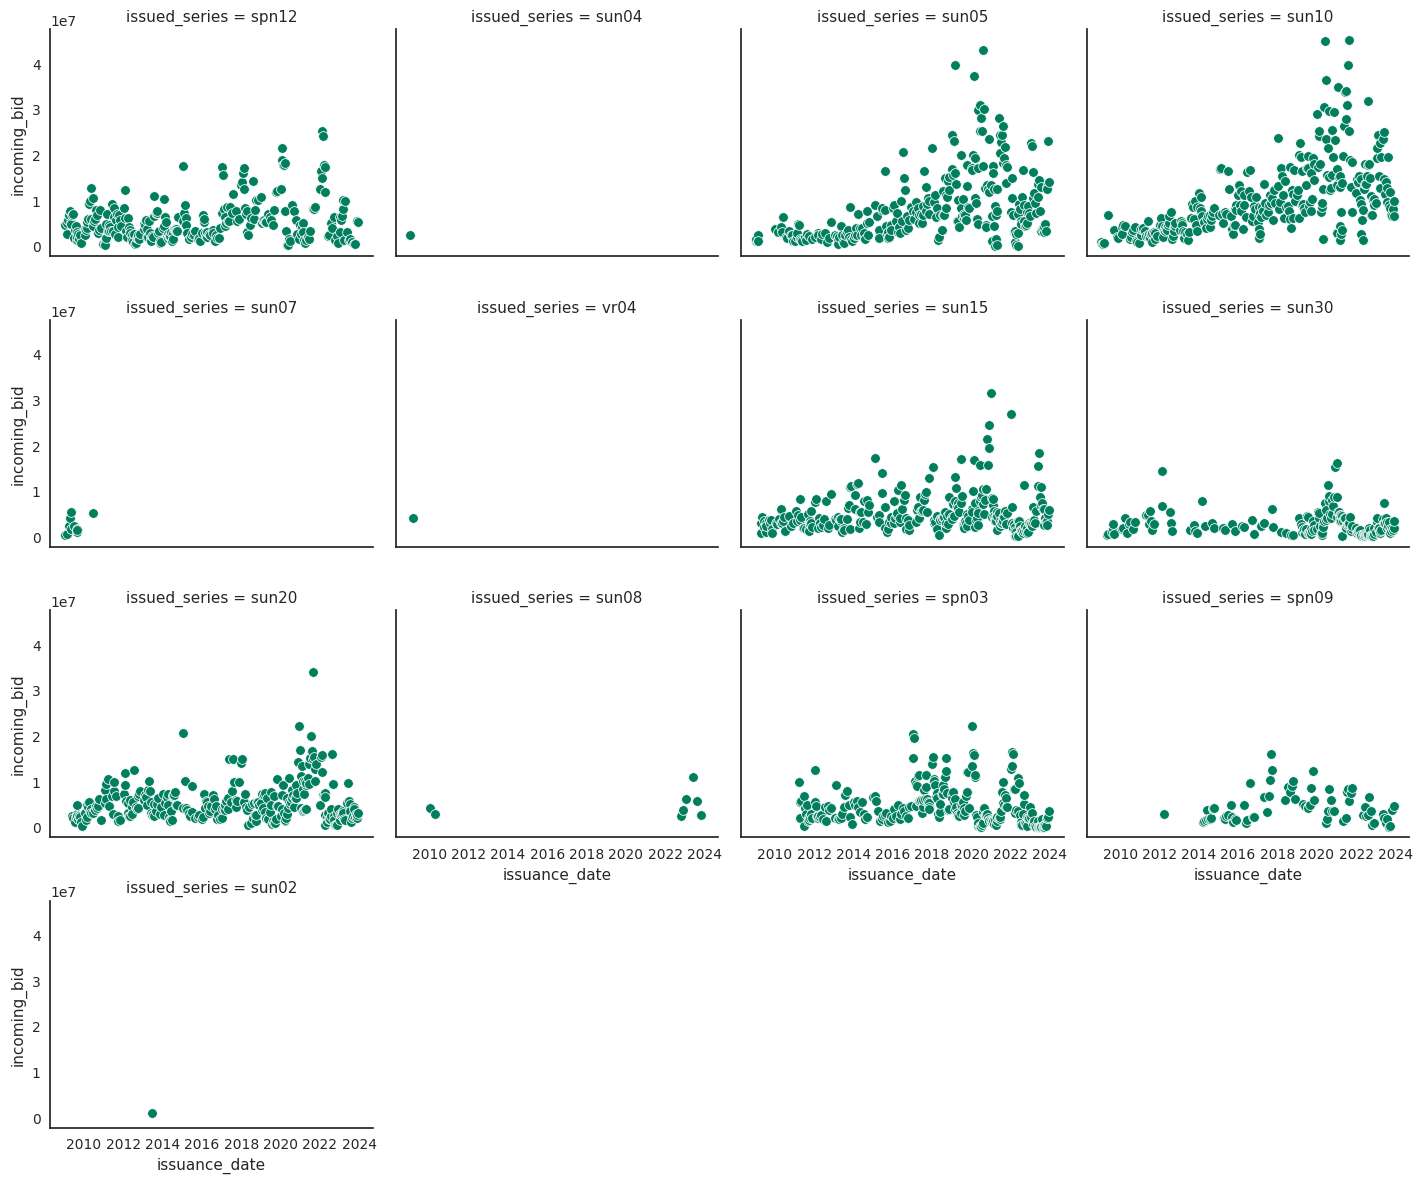

In [11]:
# import seaborn as sns
# import matplotlib.pyplot as plt

sns.set_style("white")

# Create a FacetGrid and use map to create subplots based on 'FacetVar'
ch01 = sns.FacetGrid(df_train00, col='issued_series', col_wrap=4, height=3, aspect=1.2)
ch01.map(sns.scatterplot, 'issuance_date', 'incoming_bid', color='#007e5d')

# Show the plot
# plt.show()


In [12]:
corr_matrix = df_train00.corr()
corr_matrix['incoming_bid'].sort_values(ascending=False)

incoming_bid        1.000000
issuance_year       0.249357
investment_grade    0.193326
bi_covid            0.179576
eid_weeks          -0.010284
srbi_issuance      -0.047447
vix_indicator      -0.048684
issuance_week      -0.094618
gso_issuance       -0.100791
monthfrac          -0.101150
Name: incoming_bid, dtype: float64

In [13]:
df_train01 = df_train00[~df_train00['issued_series'].isin(['sun04', 'sun02', 'vr04', 'spn09', 'sun07'])]

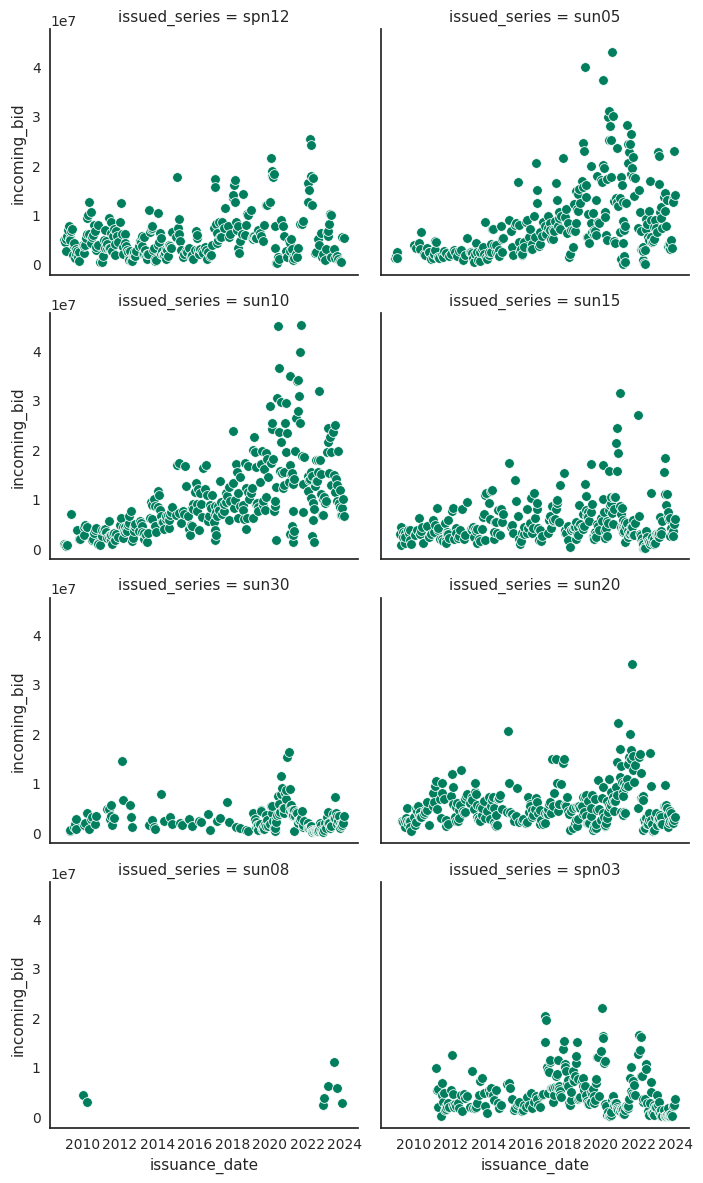

In [14]:
# import seaborn as sns
# import matplotlib.pyplot as plt

sns.set_style("white")

# Create a FacetGrid and use map to create subplots based on 'FacetVar'
ch02 = sns.FacetGrid(df_train01, col='issued_series', col_wrap=2, height=3, aspect=1.2)
ch02.map(sns.scatterplot, 'issuance_date', 'incoming_bid', color='#007e5d')

# Show the plot
# plt.show()


In [15]:
# Get the order of categories
issd_series = df_train01['issued_series'].unique()

# Sort the order
issd_series.sort()

# Create a boxplot with sorted order
# sns.boxplot(x='issued_series', y='incoming_bid', data=df_train01,
#             order=issd_series, hue='issuance_year')

# sns.boxplot(x='issued_series', y='incoming_bid', data=df_train01,
#             order=issd_series)
# plt.show()

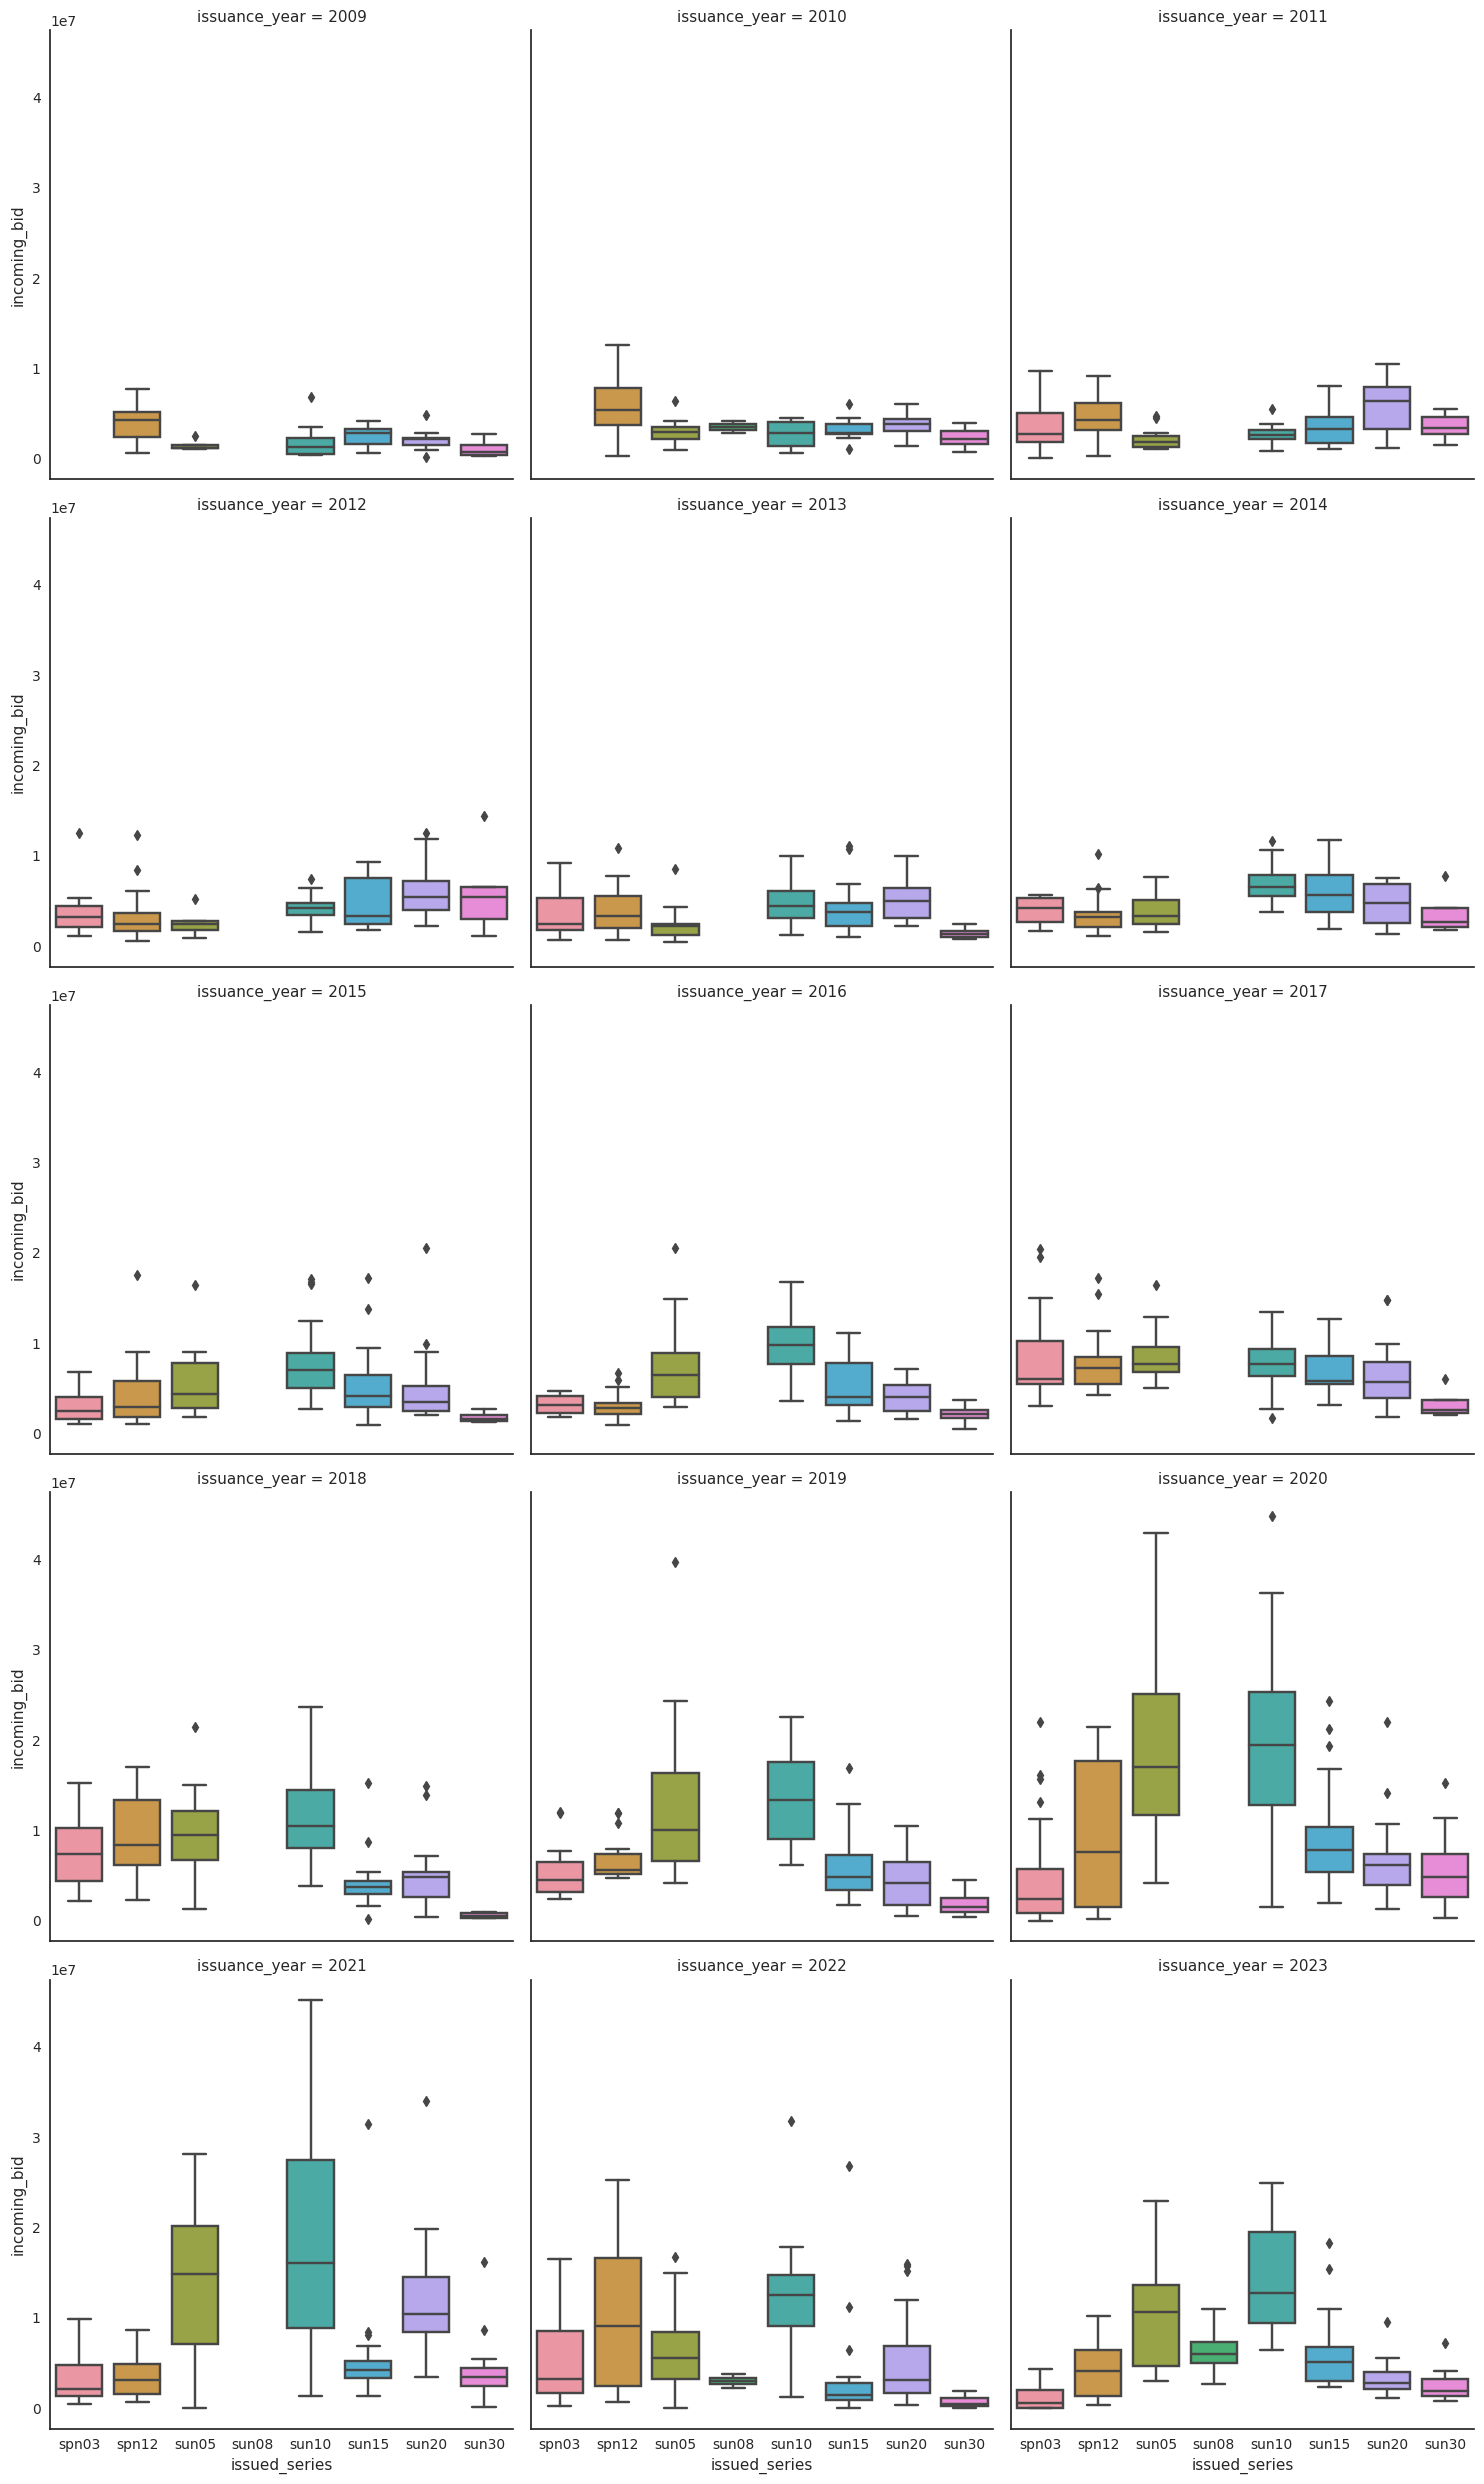

In [16]:
sns.catplot(x='issued_series', y='incoming_bid', data=df_train01,
                order=issd_series, kind='box', col='issuance_year', col_wrap=3)

### Split: Biased

In [17]:
# df_train02 = df_train01.sample(frac=0.9, random_state=786)
# df_unseen01 = df_train01.drop(df_train02.index)

# df_train02.reset_index(drop=True, inplace=True)
# df_unseen01.reset_index(drop=True, inplace=True)

# print('Data for Modeling: ' + str(df_train02.shape))
# print('Unseen Data For Predictions: ' + str(df_unseen01.shape))

In [18]:
# print("Train: \n{} \n\nTest: \n{}".format(df_train02['issued_series'].value_counts(), df_unseen01['issued_series'].value_counts()))

### Split: Stratified

In [19]:
from sklearn.model_selection import StratifiedShuffleSplit

# Assuming df is your DataFrame and 'target_column' is the target variable
split = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42)

for train_index, test_index in split.split(df_train01, df_train01['issued_series']):
    # Explicitly reset the index
    df_train02 = df_train01.iloc[train_index]
    df_unseen01 = df_train01.iloc[test_index]

# Explicitly reset the index for df_train02 and df_test01
# df_train02 = df_train02.reset_index(drop=True)
# df_unseen01 = df_unseen01.reset_index(drop=True)

# Display the shapes of the resulting sets (optional)
print("Train set shape:", df_train02.shape)
print("Test set shape:", df_unseen01.shape)

Train set shape: (1618, 12)
Test set shape: (180, 12)


In [20]:
print("Train: \n{} \n\nTest: \n{}".format(df_train02['issued_series'].value_counts(), df_unseen01['issued_series'].value_counts()))

Train: 
sun10    262
sun20    257
spn12    244
sun15    244
sun05    239
spn03    213
sun30    152
sun08      7
Name: issued_series, dtype: int64 

Test: 
sun10    29
sun20    29
sun15    27
spn12    27
sun05    26
spn03    24
sun30    17
sun08     1
Name: issued_series, dtype: int64


In [21]:
# Identifying duplicates
duplicates = df_train02[df_train02.index.duplicated()]
print("Rows with duplicate indices:")
print(duplicates)


Rows with duplicate indices:
Empty DataFrame
Columns: [issued_series, issuance_date, issuance_year, issuance_week, monthfrac, eid_weeks, srbi_issuance, vix_indicator, bi_covid, gso_issuance, investment_grade, incoming_bid]
Index: []


In [22]:
# Identifying duplicates
duplicates = df_unseen01[df_unseen01.index.duplicated()]
print("Rows with duplicate indices:")
print(duplicates)

Rows with duplicate indices:
Empty DataFrame
Columns: [issued_series, issuance_date, issuance_year, issuance_week, monthfrac, eid_weeks, srbi_issuance, vix_indicator, bi_covid, gso_issuance, investment_grade, incoming_bid]
Index: []


# Methods

## Setup

In [23]:
session01 = setup(data=df_train02, target='incoming_bid', session_id=123,
                  test_data=df_unseen01,
                  categorical_features=['issued_series'],
                  ignore_features = ['issuance_date'])

,Description,Value
0,Session id,123
1,Target,incoming_bid
2,Target type,Regression
3,Original data shape,"(1798, 12)"
4,Transformed data shape,"(1798, 18)"
5,Transformed train set shape,"(1618, 18)"
6,Transformed test set shape,"(180, 18)"
7,Ignore features,1
8,Numeric features,9
9,Categorical features,1


## Compare Models

In [24]:
best01 = compare_models(sort = 'mse')

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
xgboost,Extreme Gradient Boosting,2336383.5000,12418636002099.1992,3515095.3250,0.6583,1.1143,1.0408,0.1300
lightgbm,Light Gradient Boosting Machine,2417328.4559,12599222664879.5820,3537218.4028,0.6515,1.1486,0.9927,0.5230
rf,Random Forest Regressor,2435277.6434,13040270695282.5176,3597337.7125,0.6436,1.1616,0.9709,0.6270
et,Extra Trees Regressor,2380160.1022,13271904195087.3789,3633891.2977,0.6376,1.0776,0.8159,0.5030
gbr,Gradient Boosting Regressor,2897985.5779,17663971416655.1484,4191838.8341,0.5129,1.2121,1.3032,0.1750
knn,K Neighbors Regressor,3092259.1250,19732956079718.3984,4429559.6750,0.4503,1.2924,1.9066,0.0660
dt,Decision Tree Regressor,2968907.4584,22165123181897.6641,4658806.9828,0.4051,1.2128,0.8187,0.0630
ridge,Ridge Regression,3720224.3905,26984653574110.8438,5183388.7578,0.2601,1.4381,2.5731,0.0990
lasso,Lasso Regression,3727460.7232,26991219248966.8438,5184353.5631,0.2598,1.4541,2.5705,0.1240
lr,Linear Regression,3727800.9610,26992589055679.2930,5184501.8978,0.2597,1.4532,2.5705,0.8710


Processing:   0%|          | 0/81 [00:00<?, ?it/s]

## Features

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2647182.6605,13414789536348.9102,3662620.5832,0.5905,0.6700,0.7437
1,2246136.9386,11232572743618.1367,3351503.0574,0.7435,1.1807,0.9419
2,2215103.4061,8346433317241.1426,2889019.4387,0.7636,0.8134,2.1991
3,2464740.4761,13717371035056.8027,3703696.9416,0.6258,0.7019,0.8165
4,2464430.6894,12543933576630.6094,3541741.6022,0.6645,2.4338,1.6067
5,2351626.8941,11467758261123.7207,3386407.8699,0.5167,1.3670,0.9375
6,2603358.0740,16577678092211.2344,4071569.4876,0.6322,1.3439,0.7703
7,2278492.2224,13958772575090.5742,3736144.0785,0.6639,1.2779,0.8274
8,2476961.4638,13169731351464.1836,3629012.4485,0.6592,1.1079,0.5573


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

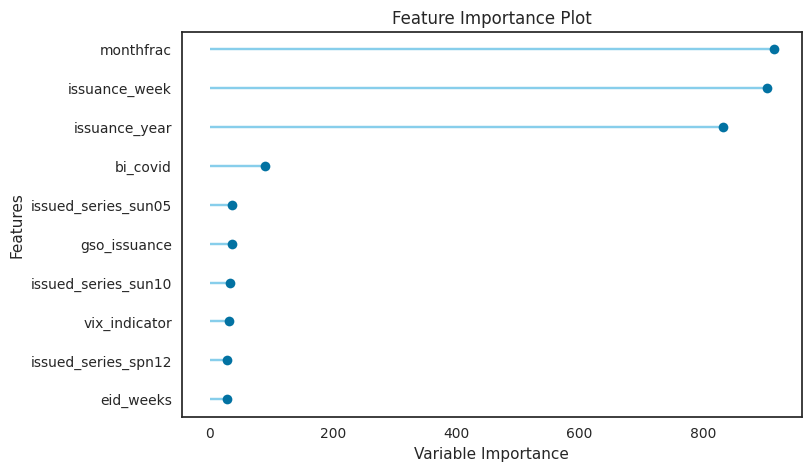

In [25]:
plot_model(create_model('lightgbm'), plot='feature')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2419651.2500,12186115112960.0000,3490861.7500,0.6280,0.6865,0.6713
1,2348913.5000,11831378706432.0000,3439677.0000,0.7298,1.2208,0.7198
2,2290971.7500,10331328872448.0000,3214238.5000,0.7074,0.8371,2.2268
3,2294070.7500,11614403166208.0000,3407991.0000,0.6831,0.7344,0.7080
4,2435498.0000,11978535862272.0000,3461002.2500,0.6796,2.3712,2.9324
5,2253700.2500,10321817239552.0000,3212758.5000,0.5650,1.3543,0.8218
6,2428490.2500,15758049411072.0000,3969641.0000,0.6504,0.9198,0.6623
7,2292685.5000,15791521005568.0000,3973854.7500,0.6198,1.2966,0.7077
8,2268872.0000,11787765284864.0000,3433331.5000,0.6949,1.2096,0.4608


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

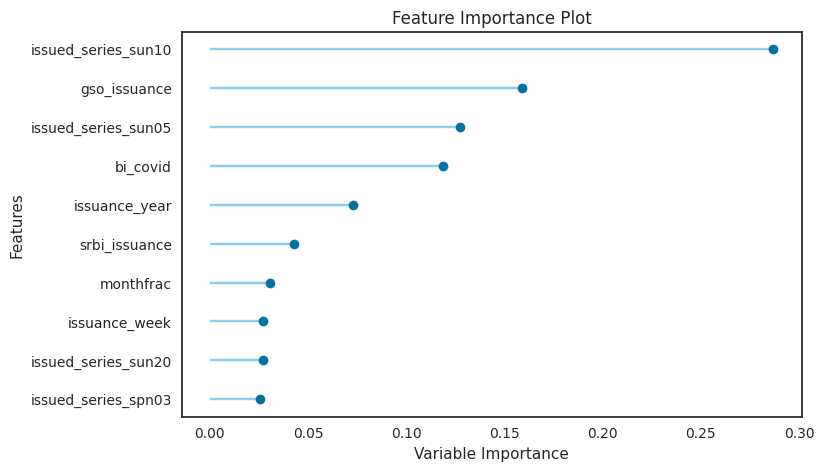

In [26]:
plot_model(create_model('xgboost'), plot='feature')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2590872.7865,13415918010861.9316,3662774.6328,0.5905,0.6817,0.7635
1,2446122.8406,12746895953892.6660,3570279.5344,0.7089,1.2906,0.8253
2,2291994.4228,10244601270085.8164,3200718.8677,0.7098,0.8522,1.9831
3,2512557.6937,14292676650376.3516,3780565.6522,0.6101,0.6050,0.6905
4,2332352.5246,12060367399166.4004,3472803.9679,0.6774,2.4163,1.8672
5,2170746.1790,9652604685761.3574,3106864.1241,0.5932,1.3524,0.8123
6,2722819.1275,18175617864290.5430,4263287.2134,0.5968,1.3343,0.8014
7,2389576.7932,15023669182694.5918,3876037.8201,0.6382,1.2798,0.8703
8,2501870.7252,12873614511028.2539,3587981.9552,0.6668,1.2788,0.5512


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

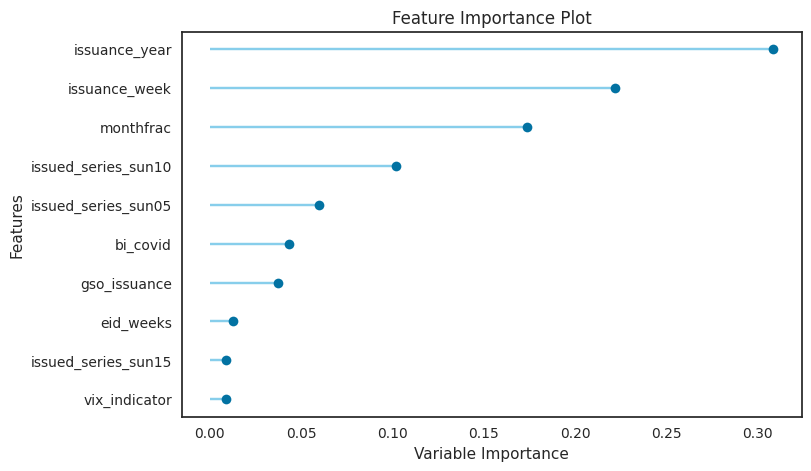

In [27]:
plot_model(create_model('rf'), plot='feature')

# Algorithms

## Light Gradient Boosting Machine

### Raw -- 65.15%

In [28]:
# train a xgb model with default params
lightgbm_raw = create_model('lightgbm')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2647182.6605,13414789536348.9102,3662620.5832,0.5905,0.6700,0.7437
1,2246136.9386,11232572743618.1367,3351503.0574,0.7435,1.1807,0.9419
2,2215103.4061,8346433317241.1426,2889019.4387,0.7636,0.8134,2.1991
3,2464740.4761,13717371035056.8027,3703696.9416,0.6258,0.7019,0.8165
4,2464430.6894,12543933576630.6094,3541741.6022,0.6645,2.4338,1.6067
5,2351626.8941,11467758261123.7207,3386407.8699,0.5167,1.3670,0.9375
6,2603358.0740,16577678092211.2344,4071569.4876,0.6322,1.3439,0.7703
7,2278492.2224,13958772575090.5742,3736144.0785,0.6639,1.2779,0.8274
8,2476961.4638,13169731351464.1836,3629012.4485,0.6592,1.1079,0.5573


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

### Tuning -- 57.59%

In [29]:
# tune hyperparameters of lightgbm
lightgbm_tuned = tune_model(lightgbm_raw)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2926463.6730,15297134415212.3398,3911155.1254,0.5331,0.8054,0.8284
1,2551326.9208,14046732861834.3145,3747897.1253,0.6792,1.2320,0.8197
2,2691348.2764,12637648100540.2910,3554946.9898,0.6420,0.8675,1.6022
3,2538194.0757,13964921559296.5781,3736966.8930,0.6190,0.7542,0.9556
4,2912222.8895,15874465416263.7539,3984277.2765,0.5754,2.4699,1.5799
5,2646159.5779,15502827563608.9883,3937363.0216,0.3467,1.4695,0.9347
6,2919063.8567,19055162087840.7578,4365221.8830,0.5773,1.3770,0.7856
7,2662766.1246,18342814838459.2266,4282851.2510,0.5583,1.2422,1.0479
8,2640386.7485,14601877546577.3633,3821240.3152,0.6221,1.2905,0.6151


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


### Modifying -- 67.81%

In [30]:

# Define a more comprehensive tuning grid for LightGBM
lightgbm_grid = {
    'learning_rate': [0.001, 0.01, 0.1, 0.2, 0.3, 0.5],
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [3, 5, 7, 9, 11],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'reg_alpha': [0, 0.1, 0.01, 0.001],
    'reg_lambda': [1, 1.5, 2, 3, 4],
    'num_leaves': [15, 31, 63, 127],
    'min_split_gain': [0, 0.1, 0.2, 0.3, 0.4],
    'subsample_freq': [0, 1, 2],
}

# Tune LightGBM model with custom grid and optimize for R2
lightgbm_modified = tune_model(lightgbm_raw, custom_grid=lightgbm_grid, optimize='mse', early_stopping=True, choose_better=True)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2534013.0219,12773702269618.6172,3574031.6548,0.6101,0.7223,0.7319
1,2273980.0455,10760172468845.0918,3280270.1823,0.7543,1.2683,0.7595
2,2061841.9505,7725211477151.3330,2779426.4655,0.7812,0.8202,1.4457
3,2457856.3732,12803419728169.1055,3578186.6536,0.6507,0.7643,0.8304
4,2428788.6804,11282944001575.4492,3359009.3780,0.6982,2.4619,1.2039
5,2131844.9804,9188732444772.0703,3031292.2071,0.6128,1.3742,0.7273
6,2485305.3277,15108130927896.6660,3886917.9214,0.6648,1.2983,0.6769
7,2327530.3626,15299944127058.6816,3911514.3010,0.6316,1.3067,0.9117
8,2336815.1780,11880242634963.5488,3446772.7855,0.6926,1.2245,0.5098


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


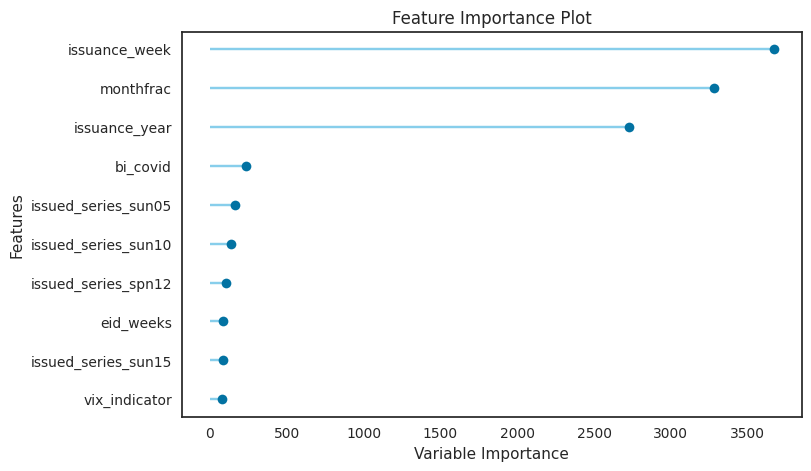

In [31]:
plot_model(lightgbm_modified, plot = 'feature')

### Bagging -- 63.91%

In [32]:
# ensemble with bagging
lightgbm_bagged = ensemble_model(lightgbm_raw, method = 'Bagging')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2660138.7480,13680776920180.0762,3698753.4279,0.5824,0.6472,0.7608
1,2300785.0967,12008324829199.2578,3465302.9924,0.7258,1.1408,0.8923
2,2245927.2928,8950084634370.6699,2991669.2054,0.7465,0.7755,1.2117
3,2439423.9874,13578594665587.9219,3684914.4720,0.6295,0.7542,0.8244
4,2466377.6328,12789313710972.1289,3576214.9979,0.6579,2.4110,2.3149
5,2390788.5977,12089420232976.0918,3476984.3590,0.4905,1.3515,0.9995
6,2641153.8702,17487747298979.9355,4181835.3984,0.6120,1.2479,0.8109
7,2376849.3551,14556476011066.7461,3815295.0097,0.6495,1.1899,0.8261
8,2523643.3282,13564595816376.8105,3683014.5012,0.6490,1.0566,0.5791


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

### Boosting -- 66.23%

In [33]:
# ensemble with boosting
lightgbm_boosted = ensemble_model(lightgbm_raw, method = 'Boosting')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2658448.0650,13431717302726.1914,3664930.7364,0.5900,0.6442,0.7653
1,2272291.4573,11521393314193.6758,3394317.7981,0.7369,1.2098,0.7002
2,2242685.2083,8982435269978.8730,2997071.1153,0.7456,0.8447,2.1468
3,2449457.5479,12147629560242.3281,3485344.9700,0.6686,0.7107,0.7948
4,2425590.7257,11392869269300.5312,3375332.4680,0.6953,2.4425,1.5658
5,2257022.2343,9821372752542.8203,3133906.9470,0.5861,1.3678,0.8725
6,2723847.9325,17285427385722.6914,4157574.7000,0.6165,1.2705,0.8328
7,2429059.5250,15458005037619.0938,3931666.9541,0.6278,1.2250,0.8840
8,2454122.7686,12247793268762.4199,3499684.7385,0.6830,1.1419,0.5611


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

## Extreme Gradient Boosting

### Raw -- 65.83%

In [34]:
# train a xgb model with default params
xgb_raw = create_model('xgboost')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2419651.2500,12186115112960.0000,3490861.7500,0.6280,0.6865,0.6713
1,2348913.5000,11831378706432.0000,3439677.0000,0.7298,1.2208,0.7198
2,2290971.7500,10331328872448.0000,3214238.5000,0.7074,0.8371,2.2268
3,2294070.7500,11614403166208.0000,3407991.0000,0.6831,0.7344,0.7080
4,2435498.0000,11978535862272.0000,3461002.2500,0.6796,2.3712,2.9324
5,2253700.2500,10321817239552.0000,3212758.5000,0.5650,1.3543,0.8218
6,2428490.2500,15758049411072.0000,3969641.0000,0.6504,0.9198,0.6623
7,2292685.5000,15791521005568.0000,3973854.7500,0.6198,1.2966,0.7077
8,2268872.0000,11787765284864.0000,3433331.5000,0.6949,1.2096,0.4608


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

### Tuning -- 66.73%

In [35]:
# tune hyperparameters of xgb
xgb_tuned = tune_model(xgb_raw)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2376856.5000,11630932918272.0000,3410415.2500,0.6450,0.6545,0.6690
1,2351804.7500,11201717207040.0000,3346896.7500,0.7442,1.3551,0.7335
2,2261082.0000,10350654128128.0000,3217243.2500,0.7068,0.7827,1.7047
3,2283312.0000,11960780324864.0000,3458436.0000,0.6737,0.6626,0.7076
4,2390577.2500,12123307507712.0000,3481854.0000,0.6757,2.3889,1.1625
5,2191807.0000,9482800201728.0000,3079415.5000,0.6004,1.3584,0.6468
6,2594699.0000,16098382577664.0000,4012279.0000,0.6429,1.2437,0.7047
7,2337875.7500,15987624640512.0000,3998452.7500,0.6150,1.3255,0.6881
8,2436827.7500,12853025177600.0000,3585111.5000,0.6674,1.2781,0.4918


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


### Modifying -- 66.93%

In [36]:
# define a more comprehensive tuning grid for XGBoost
xgb_grid = {
    'learning_rate': [0.001, 0.01, 0.1, 0.2, 0.3, 0.5],
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [3, 5, 7, 9, 11],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4],
    'reg_alpha': [0, 0.1, 0.01, 0.001],
    'reg_lambda': [1, 1.5, 2, 3, 4]
}

# tune model with custom grid and optimize for R2
xgb_modified = tune_model(xgb_raw, custom_grid=xgb_grid, optimize='mse', early_stopping=True, choose_better=True)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2581055.0000,12658345508864.0000,3557856.7500,0.6136,0.7028,0.7404
1,2206904.7500,10292061798400.0000,3208124.2500,0.7650,1.2060,0.6898
2,2151675.2500,8393332883456.0000,2897125.0000,0.7623,0.8025,1.2537
3,2301430.0000,12816850354176.0000,3580063.0000,0.6503,0.6058,0.6691
4,2519672.2500,12246186983424.0000,3499455.2500,0.6724,2.4551,1.8759
5,2277342.5000,10445484195840.0000,3231947.5000,0.5598,1.3610,0.8402
6,2543204.2500,16145909284864.0000,4018197.2500,0.6418,1.2968,0.7368
7,2403234.2500,15736315576320.0000,3966902.5000,0.6211,1.1091,0.8937
8,2379836.7500,11944587165696.0000,3456094.2500,0.6909,1.2308,0.5690


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


### Bagging -- 65.92%

In [37]:
# ensemble with bagging
xgb_bagged = ensemble_model(xgb_raw, method = 'Bagging')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2407271.0000,11647242469376.0000,3412805.7500,0.6445,0.6051,0.6777
1,2288209.0000,11518739480576.0000,3393926.7500,0.7369,0.9475,0.6894
2,2167541.0000,8724143931392.0000,2953666.2500,0.7529,0.8312,2.0929
3,2402134.5000,13112761647104.0000,3621154.7500,0.6423,0.6200,0.7379
4,2385649.7500,11623361150976.0000,3409305.0000,0.6891,2.2967,2.0261
5,2289547.5000,10953755197440.0000,3309645.7500,0.5384,1.3730,0.9440
6,2547489.5000,17064578252800.0000,4130929.5000,0.6214,1.2768,0.7251
7,2355405.0000,15672041013248.0000,3958792.7500,0.6226,1.1750,0.7862
8,2364973.2500,11962665664512.0000,3458708.7500,0.6904,1.1665,0.4902


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

### Boosting -- 67.40%

In [38]:
# ensemble with boosting
xgb_boosted = ensemble_model(xgb_raw, method = 'Boosting')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2388841.0000,12312275582976.0000,3508885.2500,0.6242,0.6038,0.6593
1,2302784.7500,11217363009536.0000,3349233.2500,0.7438,1.2161,0.6298
2,2265371.2500,9938413813760.0000,3152525.0000,0.7185,0.8450,2.2586
3,2118225.7500,9978705346560.0000,3158909.0000,0.7278,0.5719,0.5961
4,2368218.0000,10866182324224.0000,3296389.2500,0.7093,2.4662,1.4040
5,2106553.7500,9199166685184.0000,3033012.7500,0.6123,1.4087,0.7331
6,2564413.2500,16423013318656.0000,4052531.7500,0.6357,1.2988,0.7205
7,2474843.5000,16650068819968.0000,4080449.5000,0.5991,1.1748,0.8590
8,2330644.0000,11437292388352.0000,3381906.5000,0.7040,1.1461,0.4983


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

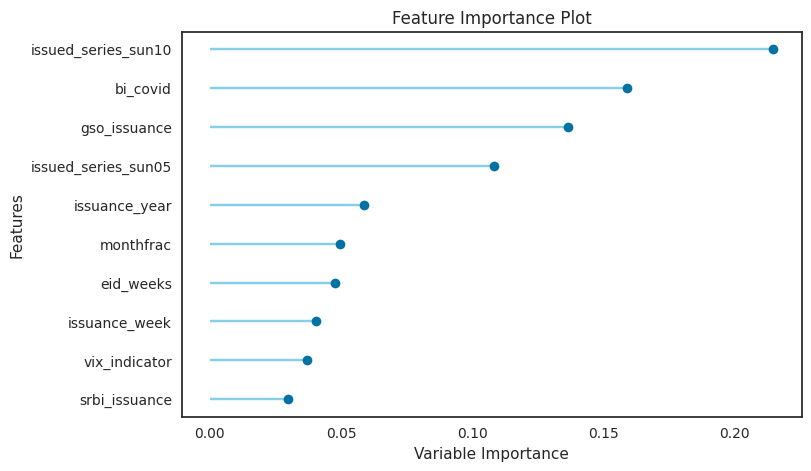

In [39]:
plot_model(xgb_boosted, plot = 'feature')

## Random Forest Regressor

### Raw -- 64.36%

In [40]:
# train a et model with default params
rf_raw = create_model('rf')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2590872.7865,13415918010861.9316,3662774.6328,0.5905,0.6817,0.7635
1,2446122.8406,12746895953892.6660,3570279.5344,0.7089,1.2906,0.8253
2,2291994.4228,10244601270085.8164,3200718.8677,0.7098,0.8522,1.9831
3,2512557.6937,14292676650376.3516,3780565.6522,0.6101,0.6050,0.6905
4,2332352.5246,12060367399166.4004,3472803.9679,0.6774,2.4163,1.8672
5,2170746.1790,9652604685761.3574,3106864.1241,0.5932,1.3524,0.8123
6,2722819.1275,18175617864290.5430,4263287.2134,0.5968,1.3343,0.8014
7,2389576.7932,15023669182694.5918,3876037.8201,0.6382,1.2798,0.8703
8,2501870.7252,12873614511028.2539,3587981.9552,0.6668,1.2788,0.5512


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

### Tuning -- 57.19%

In [41]:
# tune hyperparameters of et
rf_tuned = tune_model(rf_raw)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,3027990.9025,16917303440921.6641,4113064.9692,0.4836,0.7476,0.9957
1,2723761.1583,16182495169538.1895,4022747.2167,0.6304,1.3612,1.1677
2,2593438.4937,11532189079592.5625,3395907.6960,0.6733,0.9511,3.7093
3,2740145.7505,16649178422732.2852,4080340.4788,0.5458,0.7428,1.0072
4,2629847.4351,15601355192165.1289,3949855.0850,0.5827,2.5544,2.7422
5,2701682.8781,14114911812593.4629,3756981.7424,0.4052,1.4241,1.1836
6,2852536.2286,19849597099157.1797,4455288.6662,0.5596,1.3998,0.9256
7,2589539.5426,16872405797037.9902,4107603.4128,0.5937,1.3823,1.0363
8,2733844.1173,14482691955117.5430,3805613.2167,0.6252,1.3600,0.6918


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


### Modifying -- 61.77%

In [42]:
# define a more comprehensive tuning grid for Random Forest Regressor
rf_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 4, 8, 12],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['auto', 'sqrt', None],
    'bootstrap': [True, False]
}

# Tune model with the optimized grid and optimize for Mean Squared Error (mse)
rf_modified = tune_model(rf_raw, custom_grid=rf_grid, optimize='mse', early_stopping=True, choose_better=True)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2782192.8336,14506421507901.1172,3808729.6449,0.5572,0.6993,0.8558
1,2499573.1763,14519158095216.3066,3810401.3037,0.6684,1.3063,0.9161
2,2355679.3624,9320984139216.4453,3053028.6830,0.7360,0.8652,2.0251
3,2548499.9007,14630621827286.9238,3824999.5853,0.6008,0.6854,0.8483
4,2466829.8451,13228352943778.4863,3637080.2773,0.6462,2.4364,2.7498
5,2344145.6853,11452339461473.4473,3384130.5326,0.5174,1.2877,1.0163
6,2829308.7671,19395538862767.7812,4404036.6555,0.5697,1.3653,0.8692
7,2500724.6531,16739121279784.3945,4091347.1229,0.5969,1.3148,1.0903
8,2502725.4034,13749203820455.5762,3707991.8852,0.6442,1.2991,0.5945


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


### Bagging -- 61.96%

In [43]:
# ensemble with bagging
rf_bagged = ensemble_model(rf_raw, method = 'Bagging')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2743619.8285,14035938986691.6816,3746456.8577,0.5716,0.6985,0.8522
1,2444010.3864,13599480081627.6250,3687747.2909,0.6894,1.2953,0.9551
2,2403438.3206,9979397164262.1367,3159018.3862,0.7173,0.8758,2.0320
3,2608397.3201,15090338502583.7832,3884628.4896,0.5883,0.6936,0.8927
4,2491031.5882,13667660231144.1289,3696979.8797,0.6344,2.4565,2.9885
5,2420274.1890,11746380042100.3984,3427299.2344,0.5050,1.3863,1.0293
6,2786172.9520,18246384854517.5117,4271578.7309,0.5952,1.3693,0.8925
7,2507890.2093,16145587904966.5449,4018157.2773,0.6112,1.3243,0.9665
8,2573812.4873,13533985910705.7227,3678856.6037,0.6498,1.2987,0.6072


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

### Boosting -- 65.70%

In [44]:
# ensemble with boosting
rf_boosted = ensemble_model(rf_raw, method = 'Boosting')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2493898.9318,11646513209009.9434,3412698.8160,0.6445,0.6372,0.7423
1,2329440.8572,12040147036860.9277,3469891.5022,0.7250,1.3383,0.8826
2,2362401.4480,9400153670811.5703,3065967.0042,0.7337,0.8816,2.4982
3,2555457.6012,14822379489801.6230,3849984.3493,0.5956,0.6595,0.7961
4,2338295.6126,11268699039940.6875,3356888.2972,0.6986,2.4232,1.9763
5,2159544.9578,9241966221727.3340,3040060.2332,0.6105,1.3708,0.8749
6,2717475.6610,17169762135088.2070,4143641.1687,0.6191,1.3500,0.8524
7,2446464.0888,15636377019584.6602,3954285.9051,0.6235,1.3229,0.9343
8,2356803.7082,11411265092059.9492,3378056.4075,0.7047,1.2978,0.5499


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

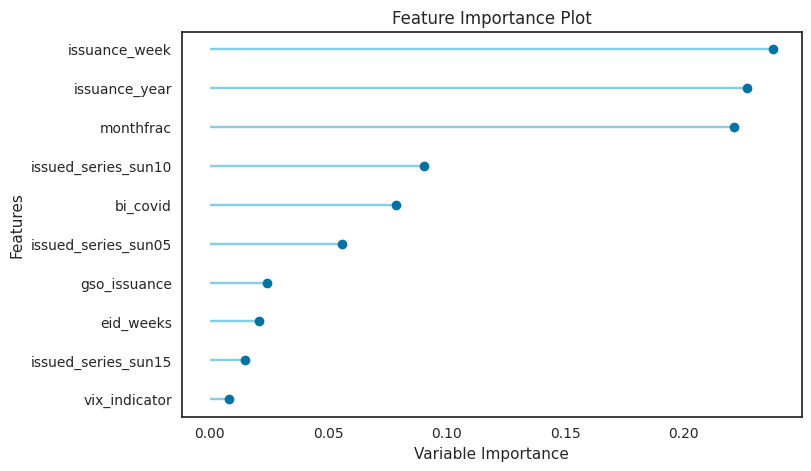

In [45]:
plot_model(rf_boosted, plot = 'feature')

# Choosen

## Blended -- 56.05%

In [46]:
# Blend the Boosted Ensembles
blended = blend_models(estimator_list=[lightgbm_modified, xgb_boosted, rf_boosted], fold=10)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2373586.9613,11546934340460.0332,3398078.0363,0.6475,0.5958,0.6697
1,2240000.0426,10730045731122.2383,3275674.8513,0.7550,1.2459,0.7242
2,2099926.2004,8042014721771.4443,2835844.6223,0.7722,0.8077,1.8390
3,2265366.3365,11346689332447.3418,3368484.7235,0.6904,0.5973,0.6658
4,2290018.1146,10400051683008.2969,3224911.1124,0.7218,2.3957,1.4996
5,2027198.9800,8665181540514.2559,2943668.0418,0.6348,1.3578,0.7308
6,2514137.7305,15431315827096.7969,3928271.3535,0.6577,1.3009,0.7225
7,2320668.4942,15135583263754.6758,3890447.6945,0.6356,1.1977,0.8292
8,2252857.2182,10998893890004.5684,3316458.0338,0.7154,1.2015,0.4889


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

In [47]:
predict_model(blended);

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Voting Regressor,2380064.9356,11783229250025.5176,3432670.8625,0.5605,1.2406,0.5340


In [48]:
# plot_model(blended, plot = 'residuals')

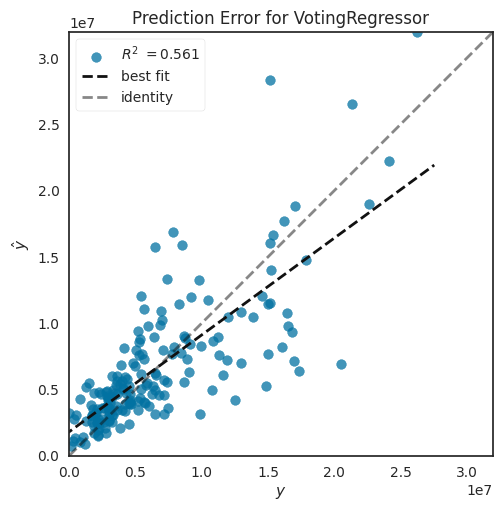

In [49]:
plot_model(blended, plot = 'error')

## Stacked -- 56.32%

In [50]:
stacked = stack_models(estimator_list=[lightgbm_modified, xgb_boosted, rf_boosted])

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2375229.1013,11548914110510.9062,3398369.3311,0.6475,0.5948,0.6710
1,2243453.5680,10705545232980.8516,3271932.9506,0.7555,1.2164,0.7169
2,2037489.1951,7668642412436.0723,2769231.3757,0.7828,0.7813,1.5714
3,2298799.6130,11729196240062.7988,3424791.4156,0.6800,0.6212,0.7101
4,2302761.1462,10629443115596.9414,3260282.6742,0.7157,2.3243,1.0323
5,2037386.5200,8732457484844.2256,2955073.1776,0.6320,1.3529,0.7529
6,2471712.4550,15091475687776.7559,3884774.8568,0.6652,1.2686,0.6814
7,2303952.5020,14772530153247.3184,3843504.9308,0.6443,1.2102,0.8181
8,2261278.1748,10912055947323.5781,3303340.1198,0.7176,1.1880,0.4838


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

In [51]:
predict_model(stacked);

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Stacking Regressor,2365516.6150,11710706570249.1387,3422090.9646,0.5632,1.2186,0.5019


In [ ]:
# plot_model(stacked, plot = 'residuals')

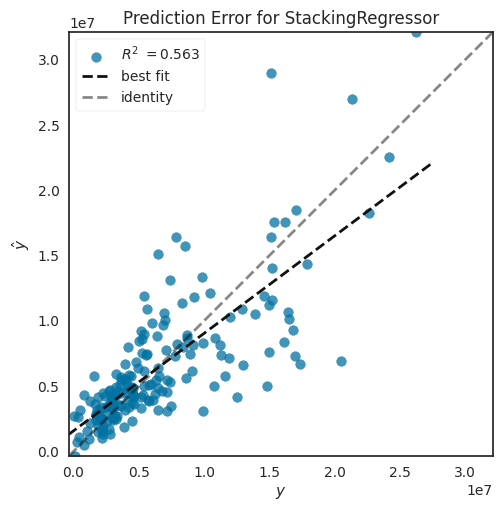

In [53]:
plot_model(stacked, plot = 'error')

## Finalizing -- 95.14%

In [54]:
final = finalize_model(stacked)
predict_model(final);

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Stacking Regressor,915256.7478,1302034644730.6875,1141067.3270,0.9514,1.0792,0.2395


# New Data

## Load

In [55]:
newdata = pd.read_excel('/content/drive/MyDrive/00database/db_monthfrac.xlsx', sheet_name='newdata')
newdata['issuance_date'] = pd.to_datetime(newdata['issuance_date'], format='%d/%m/%Y')
newdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7 entries, 0 to 6
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   issued_series     7 non-null      object        
 1   issuance_date     7 non-null      datetime64[ns]
 2   issuance_year     7 non-null      int64         
 3   issuance_week     7 non-null      int64         
 4   monthfrac         7 non-null      int64         
 5   eid_weeks         7 non-null      int64         
 6   srbi_issuance     7 non-null      int64         
 7   vix_indicator     7 non-null      int64         
 8   bi_covid          7 non-null      int64         
 9   gso_issuance      7 non-null      int64         
 10  investment_grade  7 non-null      int64         
dtypes: datetime64[ns](1), int64(9), object(1)
memory usage: 744.0+ bytes


## Predict

In [56]:
# predict model on new_data
predict01= predict_model(final, data = newdata)
predict01

,issued_series,issuance_date,issuance_year,issuance_week,monthfrac,eid_weeks,srbi_issuance,vix_indicator,bi_covid,gso_issuance,investment_grade,prediction_label
0,spn03,2024-01-03,2024,1,3,0,1,0,0,0,1,3.051136e+06
1,spn12,2024-01-03,2024,1,12,0,1,0,0,0,1,3.457567e+06
2,sun05,2024-01-03,2024,1,63,0,1,0,0,0,1,1.150470e+07
3,sun10,2024-01-03,2024,1,121,0,1,0,0,0,1,9.983773e+06
4,sun15,2024-01-03,2024,1,173,0,1,0,0,0,1,7.259672e+06
5,sun20,2024-01-03,2024,1,233,0,1,0,0,0,1,2.827900e+06
6,sun30,2024-01-03,2024,1,366,0,1,0,0,0,1,2.404524e+06


In [57]:
# !pip install --upgrade pip
# !pip install tabulate

import tabulate

# Incoming bid per series
predict02 = predict01[['issued_series', 'issuance_date', 'prediction_label']]

# Create a new column with formatted dates
predict02['issuance_date'] = predict02['issuance_date'].dt.strftime('%Y-%m-%d')

# Format the 'prediction_label' column
predict02['prediction_label'] = predict02['prediction_label'].apply(lambda x: '{:,.2f} trillion'.format(x / 1_000_000))

# Convert the DataFrame to a list of dictionaries for tabulate
table_data = predict02.to_dict(orient='records')

# Specify the column alignments
column_alignments = {'issued_series': 'left', 'issuance_date': 'center', 'prediction_label': 'right'}

# Display the formatted DataFrame using tabulate
formatted_table = tabulate.tabulate(table_data, headers="keys", floatfmt=".2f", showindex=False, colalign=list(column_alignments.values()), tablefmt="pipe")

print(formatted_table)

| issued_series   |  issuance_date  |   prediction_label |
|:----------------|:---------------:|-------------------:|
| spn03           |   2024-01-03    |      3.05 trillion |
| spn12           |   2024-01-03    |      3.46 trillion |
| sun05           |   2024-01-03    |     11.50 trillion |
| sun10           |   2024-01-03    |      9.98 trillion |
| sun15           |   2024-01-03    |      7.26 trillion |
| sun20           |   2024-01-03    |      2.83 trillion |
| sun30           |   2024-01-03    |      2.40 trillion |


In [58]:
# Sum total incoming bid
incoming_bid = predict01['prediction_label'].sum()

# Round to two decimal places
rounded_bid = round(incoming_bid, 2)
formatted_rounded_bid = 'Rp{:,.2f} million'.format(rounded_bid)

# Adjust to the nearest thousand
formatted_incoming_bid = 'Rp{:,.2f} trillion'.format(rounded_bid / 1000000)

output_message = f"""
According to the machine learning algorithm model with an R-squared value of 95.14%,
the estimated incoming bid for the next issuance is approximately {formatted_rounded_bid}
or {formatted_incoming_bid}.
"""

print(output_message)



According to the machine learning algorithm model with an R-squared value of 95.14%,
the estimated incoming bid for the next issuance is approximately Rp40,489,276.52 million
or Rp40.49 trillion.

